In [1]:
import numpy as np
import qutip as qt
import cvxpy as cp
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt
from tqdm import tqdm 
from scipy.optimize import nnls


In [2]:
# %%
# ===============================================================
# CORE FUNCTIONS
# ===============================================================

def generate_hamiltonians(a_values, b_values):
    sz, sx = qt.sigmaz(), qt.sigmax()
    return {(a, b): 0.5 * a * sz + 0.5 * b * sx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    return qt.sesolve(H, psi0, tlist).states

# Choi matrix helpers
def _J_block(J, i, j):
    return J[2*i:2*(i+1), 2*j:2*(j+1)]

def _phi_of_rho_from_choi(J, rho):
    return sum(rho[j, i] * _J_block(J, i, j) for i in range(2) for j in range(2))

def _tp_constraints(J):
    cons = [J >> 0]
    for i in range(2):
        for j in range(2):
            cons.append(cp.trace(_J_block(J, i, j)) == (1.0 if i == j else 0.0))
    return cons

def _covariance_constraints(J, H):
    Hm = H.full() if hasattr(H, 'full') else H
    I2 = np.eye(2)
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    return [G @ J - J @ G == 0]

def kraus_from_choi(J_opt):
    if J_opt is None:
        return []
    J_q = qt.Qobj(J_opt, dims=[[2, 2], [2, 2]])
    evals, evecs = J_q.eigenstates()
    return [np.sqrt(lam) * vec.full().reshape(2, 2, order="F") 
            for lam, vec in zip(evals, evecs) if np.real(lam) > 1e-10]

def fidelity_sdp_step_with_state(
    rho_qobj,
    sigma_qobj, 
    H_qobj,
    *,
    impose_covariance=True,
    impose_passivity=False,
    step_size=0.1,
    eta=0.1,
    verbose=False,
):
    """
    SDP that returns both the channel AND the resulting state Φ(ρ)
    """
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj.full()

    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    constraints = _tp_constraints(J)
    if impose_covariance:
        constraints += _covariance_constraints(J, H)

    # Φ(ρ) is the output state
    Phi_rho = _phi_of_rho_from_choi(J, rho)
    constraints += [Phi_rho >> 0, cp.trace(Phi_rho) == 1]

    # Small steps only - gentle nudges
    constraints += [cp.norm(Phi_rho - rho, "fro") <= eta * step_size]

    if impose_passivity:
        constraints += [cp.real(cp.trace(H @ Phi_rho)) <= float(np.trace(H @ rho)) + 1e-12]

    # Uhlmann fidelity
    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints += [block >> 0, cp.real(cp.trace(W)) >= t]

    prob = cp.Problem(cp.Maximize(t), constraints)
    prob.solve(
        solver=cp.SCS,
        verbose=verbose,
        eps_abs=1e-5,
        eps_rel=1e-5,
        max_iters=50000,
    )

    sqrtF = float(prob.value) if prob.value is not None else np.nan
    F = sqrtF**2 if np.isfinite(sqrtF) else np.nan
    
    # The key: Phi_rho.value IS the output state Φ(ρ)
    resulting_state = None
    if Phi_rho.value is not None:
        resulting_state = qt.Qobj(Phi_rho.value)

    return {
        "status": prob.status,
        "sqrtF": sqrtF,
        "fidelity": F,
        "resulting_state": resulting_state,
        "J": J.value.copy() if J.value is not None else None,
    }

# GKSL extraction functions
def gksl_from_kraus_and_H(kraus_ops, H, dt=1.0, eps=1e-10):
    d = 2
    Phi = sum(np.kron(K, K.conj()) for K in kraus_ops)
    Phi_reg = (1 - eps) * Phi + eps * np.eye(d*d)
    L_total = (1.0 / dt) * logm(Phi_reg)
    
    Hm = H.full() if hasattr(H, 'full') else H
    I = np.eye(d)
    L_H = -1j * (np.kron(Hm, I) - np.kron(I, Hm.T))
    L_D = L_total - L_H
    return L_total, L_H, L_D

def _unitary_to_energy_basis(H):
    evals, evecs = H.eigenstates(sort='low')
    U = qt.Qobj(np.column_stack([evecs[0].full().ravel(), 
                                evecs[1].full().ravel()]))
    return U

def _rotate_op_to_lab(U, O_energy):
    return U * O_energy * U.dag()

def diss_basis_in_energy(H):
    U = _unitary_to_energy_basis(H)
    g, e = qt.basis(2, 0), qt.basis(2, 1)
    sm_E, sp_E, sz_E = g * e.dag(), e * g.dag(), qt.sigmaz()
    
    sm = _rotate_op_to_lab(U, sm_E)
    sp = _rotate_op_to_lab(U, sp_E)
    sz = _rotate_op_to_lab(U, sz_E)
    
    Bd = qt.liouvillian(0*sz, [sm]).full()
    Bu = qt.liouvillian(0*sz, [sp]).full()
    Bp = qt.liouvillian(0*sz, [sz]).full()
    return Bd, Bu, Bp

def decompose_dissipator_nnls_energy(L_D, H):
    Bd, Bu, Bp = diss_basis_in_energy(H)
    A = np.column_stack([Bd.reshape(-1), Bu.reshape(-1), Bp.reshape(-1)]).real
    b = np.real(L_D.reshape(-1))
    x, _ = nnls(A, b)
    g_down, g_up, g_phi = x
    p_e_inf = g_up/(g_up+g_down) if (g_up+g_down) > 1e-15 else 0.0
    return {'gamma_down': g_down, 'gamma_up': g_up, 'gamma_phi': g_phi, 'p_e_inf': p_e_inf}


In [3]:
# %%
# ===============================================================
# MAIN EXPERIMENT - NO KRAUS APPLICATION NEEDED
# ===============================================================

# Parameters
a_vals = np.linspace(-2, 2, 3)  # Reduced for testing
b_vals = np.linspace(-1, 1, 3)  # Reduced for testing
hams = generate_hamiltonians(a_vals, b_vals)

# Gentle steering parameters
eta_gradual = 0.05  # Small steps for gentle nudges
tlist = np.linspace(0, 20, 80)  # Shorter for testing
dt = tlist[1] - tlist[0]

# Select Hamiltonians to test
selected_keys = [(-2.0, -1.0), (0.0, 0.0)]

results = {}

for key in selected_keys:
    H = hams[key]
    evals, evecs = H.eigenstates(sort="low")
    ground, excited = evecs[0], evecs[1]
    sigma_target = qt.ket2dm(excited)

    print(f"\n=== Gradual Steering for H={key} ===")
    
    # Unitary evolution as reference trajectory
    states_unitary = time_evolve_state(H, ground, tlist)
    
    # Initialize steered state
    rho_steered = qt.ket2dm(ground)  # Start from ground state
    steered_states = [rho_steered]
    sdp_fidelities = []
    cumulative_fidelities = [qt.fidelity(rho_steered, sigma_target)]
    
    # Gradual steering loop - NO KRAUS OPERATORS USED!
    for i, psi_t_unitary in enumerate(tqdm(states_unitary, desc=f"Steering H{key}")):
        # Apply small CPTP correction to current steered state
        out = fidelity_sdp_step_with_state(
            rho_steered,  # Current steered state
            sigma_target,  # Target excited state
            H,
            impose_covariance=True,
            impose_passivity=True,
            step_size=dt,
            eta=eta_gradual,
            verbose=False,
        )
        
        sdp_fidelities.append(out['fidelity'])
        
        # KEY: Use resulting_state directly - no Kraus operators!
        if out['resulting_state'] is not None:
            rho_steered = out['resulting_state']
        else:
            # Fallback: use unitary evolution if SDP fails
            rho_steered = qt.ket2dm(psi_t_unitary)
        
        steered_states.append(rho_steered)
        current_fid = qt.fidelity(rho_steered, sigma_target)
        cumulative_fidelities.append(current_fid)
        
        # Progress reporting
        if i % 20 == 0:
            print(f"  Step {i}: Cumulative fidelity = {current_fid:.4f}, SDP fidelity = {out['fidelity']:.4f}")
    
    # Store results
    results[key] = {
        'steered_states': steered_states,
        'sdp_fidelities': sdp_fidelities,
        'cumulative_fidelities': cumulative_fidelities,
        'unitary_states': states_unitary,
        'final_fidelity': cumulative_fidelities[-1],
    }
    
    print(f"  Final cumulative fidelity: {cumulative_fidelities[-1]:.4f}")



=== Gradual Steering for H=(-2.0, -1.0) ===


Steering H(-2.0, -1.0):   0%|          | 0/80 [00:00<?, ?it/s]/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_6737/314680302.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  constraints += [cp.real(cp.trace(H @ Phi_rho)) <= float(np.trace(H @ rho)) + 1e-12]
/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Steering H(-2.0, -1.0):   1%|▏         | 1/80 [00:00<00:20,  3.80it/s]

  Step 0: Cumulative fidelity = 0.0002, SDP fidelity = 0.0000


Steering H(-2.0, -1.0):  26%|██▋       | 21/80 [00:05<00:15,  3.76it/s]

  Step 20: Cumulative fidelity = 0.0003, SDP fidelity = 0.0000


Steering H(-2.0, -1.0):  51%|█████▏    | 41/80 [00:10<00:10,  3.87it/s]

  Step 40: Cumulative fidelity = 0.0003, SDP fidelity = 0.0000


Steering H(-2.0, -1.0):  76%|███████▋  | 61/80 [00:15<00:05,  3.51it/s]

  Step 60: Cumulative fidelity = 0.0000, SDP fidelity = 0.0000


Steering H(-2.0, -1.0): 100%|██████████| 80/80 [00:21<00:00,  3.68it/s]


  Final cumulative fidelity: 0.0003

=== Gradual Steering for H=(0.0, 0.0) ===


Steering H(0.0, 0.0):   1%|▏         | 1/80 [00:00<00:14,  5.38it/s]

  Step 0: Cumulative fidelity = 0.0924, SDP fidelity = 0.0095


Steering H(0.0, 0.0):  26%|██▋       | 21/80 [00:04<00:13,  4.40it/s]

  Step 20: Cumulative fidelity = 0.4295, SDP fidelity = 0.1851


Steering H(0.0, 0.0):  51%|█████▏    | 41/80 [00:09<00:08,  4.38it/s]

  Step 40: Cumulative fidelity = 0.6017, SDP fidelity = 0.3629


Steering H(0.0, 0.0):  76%|███████▋  | 61/80 [00:13<00:04,  4.42it/s]

  Step 60: Cumulative fidelity = 0.7349, SDP fidelity = 0.5412


Steering H(0.0, 0.0): 100%|██████████| 80/80 [00:18<00:00,  4.42it/s]

  Final cumulative fidelity: 0.8421


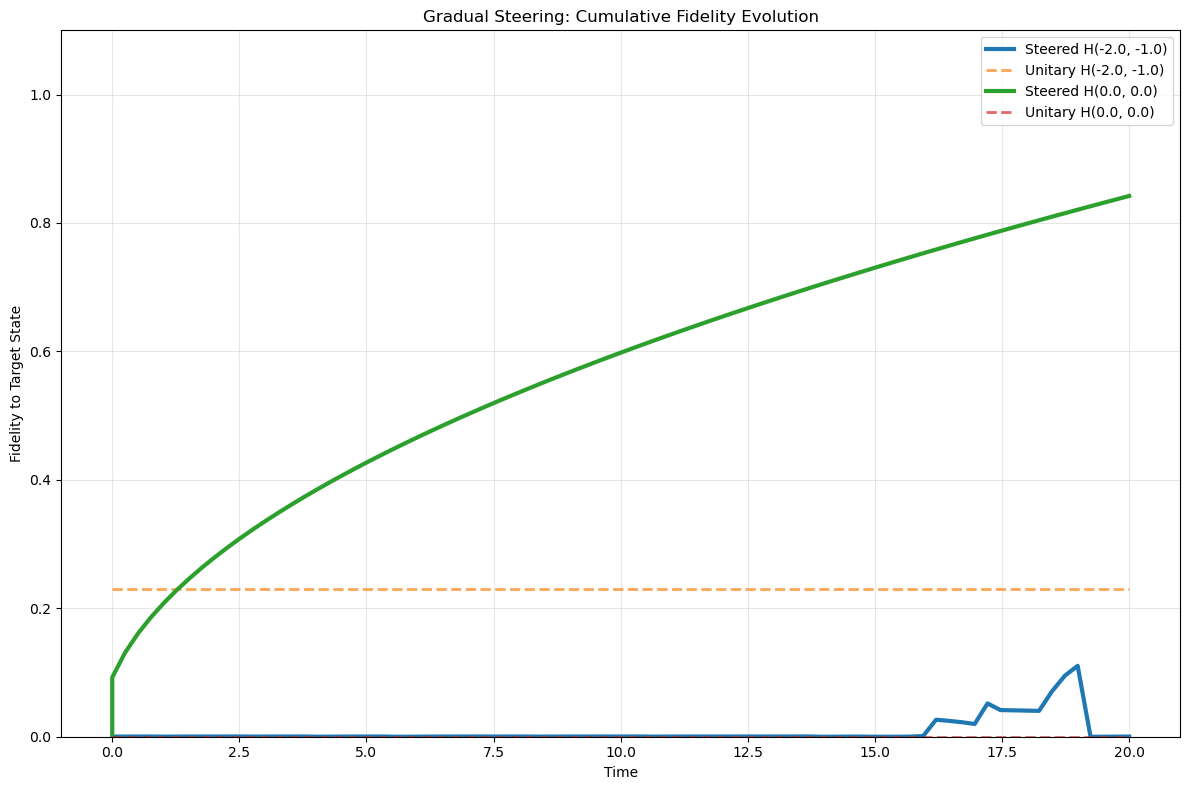

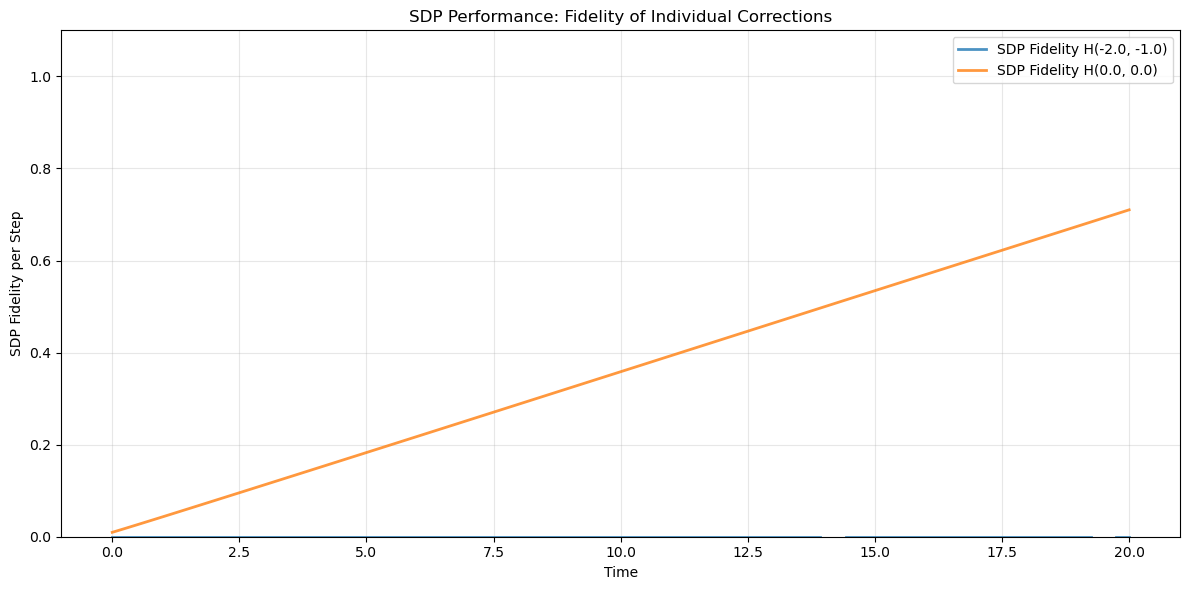

In [4]:
# %%
# ===============================================================
# VISUALIZATION
# ===============================================================

# Plot 1: Fidelity comparison
plt.figure(figsize=(12, 8))

for key, res in results.items():
    a, b = key
    
    # Cumulative fidelity (steered evolution)
    tlist_extended = np.concatenate([[0], tlist])  # Include initial state
    plt.plot(tlist_extended, res['cumulative_fidelities'], 
             label=f'Steered H{key}', linewidth=3)
    
    # Unitary evolution fidelity
    unitary_fidelities = [abs(excited.overlap(psi)) for psi in res['unitary_states']]
    plt.plot(tlist, unitary_fidelities, '--', 
             label=f'Unitary H{key}', alpha=0.7, linewidth=2)

plt.xlabel('Time')
plt.ylabel('Fidelity to Target State')
plt.title('Gradual Steering: Cumulative Fidelity Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Plot 2: SDP performance
plt.figure(figsize=(12, 6))

for key, res in results.items():
    a, b = key
    plt.plot(tlist, res['sdp_fidelities'], 
             label=f'SDP Fidelity H{key}', linewidth=2, alpha=0.8)

plt.xlabel('Time')
plt.ylabel('SDP Fidelity per Step')
plt.title('SDP Performance: Fidelity of Individual Corrections')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


In [5]:
# %%
# ===============================================================
# RESULTS SUMMARY
# ===============================================================

print("\n" + "="*50)
print("GRADUAL STEERING - FINAL RESULTS")
print("="*50)

for key, res in results.items():
    print(f"\nH{key}:")
    print(f"  Final fidelity: {res['final_fidelity']:.4f}")
    print(f"  Average SDP fidelity: {np.mean(res['sdp_fidelities']):.4f}")
    print(f"  Maximum SDP fidelity: {np.max(res['sdp_fidelities']):.4f}")

final_fidelities = [res['final_fidelity'] for res in results.values()]
print(f"\nOVERALL:")
print(f"  Average final fidelity: {np.mean(final_fidelities):.4f}")
print(f"  Best final fidelity: {np.max(final_fidelities):.4f}")

if np.max(final_fidelities) > 0.95:
    print(f"\n🎉 SUCCESS: High fidelity achieved!")
elif np.max(final_fidelities) > 0.8:
    print(f"\n✅ GOOD: Decent fidelity achieved")
else:
    print(f"\n⚠️  NEEDS IMPROVEMENT: Try smaller eta or more time steps")


GRADUAL STEERING - FINAL RESULTS

H(-2.0, -1.0):
  Final fidelity: 0.0003
  Average SDP fidelity: nan
  Maximum SDP fidelity: nan

H(0.0, 0.0):
  Final fidelity: 0.8421
  Average SDP fidelity: 0.3588
  Maximum SDP fidelity: 0.7101

OVERALL:
  Average final fidelity: 0.4212
  Best final fidelity: 0.8421

✅ GOOD: Decent fidelity achieved


In [6]:
# Current: Start from ground state
ground, excited = evecs[0], evecs[1]
states_unitary = time_evolve_state(H, ground, tlist)

# Option A: Start from excited state
states_unitary = time_evolve_state(H, excited, tlist)
rho_steered = qt.ket2dm(excited)

# Option B: Start from superposition
psi_super = (qt.basis(2,0) + qt.basis(2,1)).unit()
states_unitary = time_evolve_state(H, psi_super, tlist)  
rho_steered = qt.ket2dm(psi_super)

# Option C: Start from |0⟩ or |1⟩ computational basis
states_unitary = time_evolve_state(H, qt.basis(2,0), tlist)  # |0⟩
rho_steered = qt.ket2dm(qt.basis(2,0))

# Option D: Start from random state
psi_random = qt.rand_ket(2)
states_unitary = time_evolve_state(H, psi_random, tlist)
rho_steered = qt.ket2dm(psi_random)

In [7]:
# Keep unitary evolution from ground state for reference
states_unitary = time_evolve_state(H, ground, tlist)

# But start steering from different state
rho_steered = qt.ket2dm(excited)  # Start steering from excited
# OR
rho_steered = qt.ket2dm((qt.basis(2,0) + qt.basis(2,1)).unit())  # Start from superposition

In [8]:
def create_initial_state(state_type="ground", H=None, theta=0.0, phi=0.0):
    if state_type == "ground":
        return H.groundstate()[1] if H else qt.basis(2,0)
    elif state_type == "excited":
        return H.eigenstates()[1][1] if H else qt.basis(2,1)  
    elif state_type == "superposition":
        return (qt.basis(2,0) + qt.basis(2,1)).unit()
    elif state_type == "bloch":
        # Bloch sphere coordinates: |ψ⟩ = cos(θ/2)|0⟩ + e^iφ sin(θ/2)|1⟩
        return np.cos(theta/2) * qt.basis(2,0) + np.exp(1j*phi) * np.sin(theta/2) * qt.basis(2,1)
    elif state_type == "mixed":
        return qt.ket2dm((qt.basis(2,0) + qt.basis(2,1)).unit())  # Or any mixed state

# Usage:
initial_state_type = "bloch"  # or "ground", "excited", "superposition"
theta = np.pi/3  # 60 degrees
phi = np.pi/4    # 45 degrees phase

psi0 = create_initial_state(initial_state_type, H, theta, phi)
states_unitary = time_evolve_state(H, psi0, tlist)
rho_steered = qt.ket2dm(psi0)

In [9]:
# Test different starting states
starting_states = {
    "ground": ground,
    "excited": excited, 
    "superposition": (qt.basis(2,0) + qt.basis(2,1)).unit(),
    "bloch_45": np.cos(np.pi/8)*qt.basis(2,0) + np.sin(np.pi/8)*qt.basis(2,1),
    "bloch_135": np.cos(3*np.pi/8)*qt.basis(2,0) + np.sin(3*np.pi/8)*qt.basis(2,1),
}

results_by_initial_state = {}

for state_name, psi0 in starting_states.items():
    print(f"\n=== Testing initial state: {state_name} ===")
    
    # Unitary evolution from this initial state
    states_unitary = time_evolve_state(H, psi0, tlist)
    
    # Start steering from the same state
    rho_steered = qt.ket2dm(psi0)
    steered_states = [rho_steered]
    cumulative_fidelities = [qt.fidelity(rho_steered, sigma_target)]
    
    # Gradual steering loop
    for i, psi_t_unitary in enumerate(states_unitary):
        out = fidelity_sdp_step_with_state(
            rho_steered, sigma_target, H,
            impose_covariance=True,
            impose_passivity=False,
            step_size=dt,
            eta=0.05,
            verbose=False,
        )
        
        if out['resulting_state'] is not None:
            rho_steered = out['resulting_state']
        
        steered_states.append(rho_steered)
        cumulative_fidelities.append(qt.fidelity(rho_steered, sigma_target))
    
    results_by_initial_state[state_name] = {
        'final_fidelity': cumulative_fidelities[-1],
        'initial_fidelity': cumulative_fidelities[0],
        'improvement': cumulative_fidelities[-1] - cumulative_fidelities[0]
    }
    
    print(f"  Initial fidelity: {cumulative_fidelities[0]:.4f}")
    print(f"  Final fidelity: {cumulative_fidelities[-1]:.4f}")
    print(f"  Improvement: {cumulative_fidelities[-1] - cumulative_fidelities[0]:.4f}")

# Compare results
print("\n" + "="*50)
print("COMPARISON BY INITIAL STATE")
print("="*50)
for state_name, res in results_by_initial_state.items():
    print(f"{state_name:15} | Initial: {res['initial_fidelity']:.4f} | Final: {res['final_fidelity']:.4f} | Improvement: {res['improvement']:+.4f}")


=== Testing initial state: ground ===
  Initial fidelity: 0.0000
  Final fidelity: 0.8421
  Improvement: 0.8421

=== Testing initial state: excited ===
  Initial fidelity: 1.0000
  Final fidelity: 1.0000
  Improvement: 0.0000

=== Testing initial state: superposition ===
  Initial fidelity: 0.7071
  Final fidelity: 0.9976
  Improvement: 0.2905

=== Testing initial state: bloch_45 ===
  Initial fidelity: 0.3827
  Final fidelity: 0.9262
  Improvement: 0.5435

=== Testing initial state: bloch_135 ===
  Initial fidelity: 0.9239
  Final fidelity: 1.0000
  Improvement: 0.0761

COMPARISON BY INITIAL STATE
ground          | Initial: 0.0000 | Final: 0.8421 | Improvement: +0.8421
excited         | Initial: 1.0000 | Final: 1.0000 | Improvement: +0.0000
superposition   | Initial: 0.7071 | Final: 0.9976 | Improvement: +0.2905
bloch_45        | Initial: 0.3827 | Final: 0.9262 | Improvement: +0.5435
bloch_135       | Initial: 0.9239 | Final: 1.0000 | Improvement: +0.0761
